In [426]:
import  pandas as pd
import glob
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import filtfilt, firwin2, firwin, freqz, kaiserord, lfilter, butter, welch

# helper functions

In [434]:
def bandpower(data, sf, band, output = False):
    band = np.asarray(band)
    low, high = band
    print(low, sf, (2 / low)*sf)
0.1 173.60169491525423 3472.0338983050847
    # Compute the periodogram (Welch)
    freqs, psd = welch(data, 
                       sf, 
                       nperseg=(2 / low)*sf,
                       scaling='density', 
                       axis=0)
    
    # put into a df
    psd = pd.DataFrame(psd, index = freqs, columns = data.columns)
    
    if output:
        print(color.BOLD+'Welch Output'+color.END)
        psd.index.name = 'Hz'
        psd.columns = ['Power']
        display(psd)
    
    # Find closest indices of band in frequency vector
    idx_min = np.argmax(np.round(freqs) > low) - 1
    idx_max = np.argmax(np.round(freqs) > high)
    
    # select frequencies of interest
    psd = psd.iloc[idx_min:idx_max,:]
    
    # get the mean of each channel over all frequencies in the band
    psd = psd.mean()
    
    if output:
        print(color.BOLD+'\nMean Frequency Band'+color.END)
        display(psd)
    
    return psd


def power_measures(data, sample_rate, output=False):
    bandpasses = [[[0.1,4],'power_delta'],
                  [[4,8],'power_theta'],
                  [[8,12],'power_alpha'],
                  [[12,30],'power_beta'],
                  [[30,70],'power_gamma']
                 ]
    
    welch_df = pd.DataFrame()
    for bandpass, freq_name in bandpasses:
        bandpass_data = bandpower(data, sample_rate, bandpass)
        bandpass_data.index = [freq_name]
        
        if welch_df.empty:
            welch_df = bandpass_data

        else:
            welch_df = pd.concat([welch_df, bandpass_data])
        
    welch_df = welch_df.T
    
    if output:
        display(welch_df)
    
    return welch_df

# import data from directories

In [570]:
files = glob.glob('datasets/*/*.[tT][xX][tT]')
li = []

for i in tqdm(range(len(files))):
    #print(file)
    df = pd.read_csv(files[i])
    li.append(pd.DataFrame.transpose(df))

df = pd.concat(li)

# add target variable on the end
df['target'] = np.concatenate([np.repeat(0, 400), np.repeat(1, 100)])
df.to_csv('data.csv', index = False)

100%|██████████| 500/500 [00:01<00:00, 258.05it/s]


In [142]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,target
-76,-10,31,44,7,-55,-51,-40,-11,-23,-27,...,184,164,145,167,185,245,209,150,-51,0
34,31,29,19,16,12,3,-1,-5,-8,-8,...,-22,-18,-14,-10,-9,0,5,3,-29,0
-57,-70,-78,-67,-57,-57,-57,-54,-43,-41,-34,...,-69,-59,-45,-26,-29,-36,-48,-57,11,0
-4,-6,-6,-1,-11,-22,-13,-13,-6,-14,-26,...,-23,-3,7,21,11,11,10,6,100,0
-41,-35,-28,-23,-20,-22,-28,-33,-30,-31,-25,...,16,10,11,10,8,8,2,-7,28,0


In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, -76 to -53
Columns: 4097 entries, 0 to target
dtypes: int64(4097)
memory usage: 15.6+ MB


In [144]:
df.shape

(500, 4097)

# use scipy to take the FFT
for now, lets take just one signal

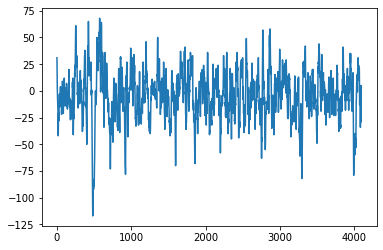

In [324]:
signal = df.iloc[1, :].values
plt.plot(signal)

In [520]:
N = len(signal2)
sf = N / 23.6 # number of samples in 1 s
nyq_rate = sf / 2  # nyquist rate of the signal
dt = 1/sf
T = N * dt
x = np.linspace(0.0, T, N, endpoint=False)
print(dt, N, T)

0.005760312423724677 4097 23.6


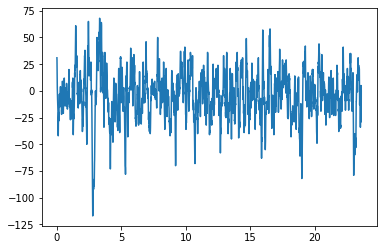

In [522]:
plt.plot(x, signal2)

# Design FIR low-pass filter

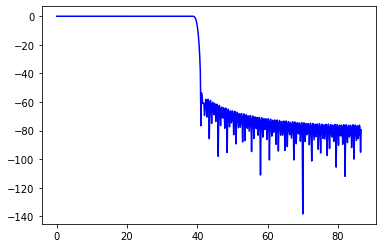

In [171]:
f_pass = 40.
freq = np.array([0, f_pass, f_pass, nyq_rate])
gain = [1, 1, 0, 0]


# Width of the roll-off region.
width = 5. / nyq_rate

# Attenuation in the stop band.
ripple_db = 120.

numtaps, beta = kaiserord(ripple_db, width)

if numtaps % 2 == 0:
    numtaps += 1

# Use firwin2 to create a lowpass FIR filter.
taps = firwin2(numtaps, freq, gain=gain, nyq=nyq_rate)
w, h = freqz(taps)
plt.plot((w / np.pi) * nyq_rate, 20 * np.log10(abs(h)), '-b')


# Use butterworth low-pass filter
scipy.signal.filtfilt, a linear filter that achieves zero phase delay by applying an IIR filter to a signal twice, once forwards and once backwards. 

In [174]:
b, a = butter(8, 40/nyq_rate)
filtered_signal = filtfilt(b, a, signal, padlen=150)

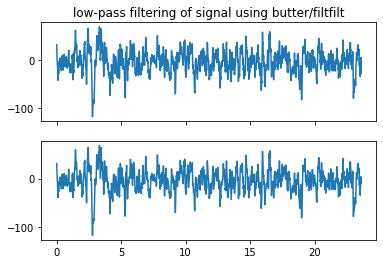

In [175]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(x, signal)
ax1.set_title('low-pass filtering of signal using butter/filtfilt')
ax2.plot(x, filtered_signal)


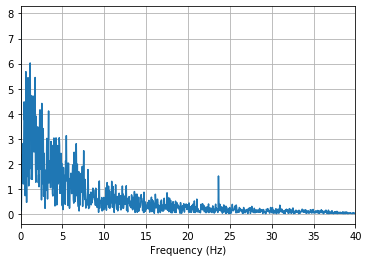

In [178]:
xf = fftfreq(N, dt)[:N//2]
yf = fft(filtered_signal)
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.xlabel('Frequency (Hz)')
plt.xlim([0, 40])
plt.grid()

only compute the non-negative frequency terms in the FFT. FFT output is symmetric

When the DFT is computed for purely real input, the output is Hermitian-symmetric, i.e. the negative frequency terms are just the complex conjugates of the corresponding positive-frequency terms, and the negative-frequency terms are therefore redundant. This function does not compute the negative frequency terms, and the length of the transformed axis of the output is therefore n//2 + 1

4097


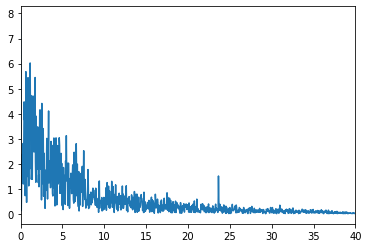

In [179]:
power = np.abs(np.fft.rfft(filtered_signal, N))
ff = np.fft.rfftfreq(N, 1. / sf)
plt.plot(ff, 2.0/N * np.abs(power))
plt.xlim([0, 40])
print(N)

# you can see that we have resolution in the frequency domain but we don't know where in time those frequencies are turning on and off

Introducing the welch method
The FFT method applies a fourier decomposition over the entire signal. But if the signal is non-stationary, i.e. mean and variance is not constant, the FFT does not tell you where in the signal the frequency turned on. You don't know about the non-stationarities or temporal dynamics just by looking at the FFT.



# Welch's method
Welch method will isolate a tiny segment of the time series. Take the segment, multiply by a window function and then perform an fft. Cutting off the signal at the end will result in spectral leakage. One way to overcome this is to attenuate the signal at the ends of the segment. A parameter of welch is the amount of overlap between windows (usually 50%). The overlap accounts for the attenuation at the ends due to windowing. At the end, we average the across frequency to obtain a smooth estimate of the power.

In contrast to FFT, welch is not sensitive to noise, it is robust to non-stationarities. However, it does have reduced spectral resolution as the expense of temporal resolution.

Here we calculate the welch power spectrum for different window sizes
the window size is determined by the lowest frequency we are interested in nperseg = (2 / low)*sample_rate # this ensures there at least 2 cycles
of the lowest frequency in the window.

In [435]:
powers = power_measures(pd.DataFrame(filtered_signal), sf)
powers

0.1 173.60169491525423 3472.0338983050847
4 173.60169491525423 86.80084745762711
8 173.60169491525423 43.40042372881356
12 173.60169491525423 28.933615819209038
30 173.60169491525423 11.573446327683616


power_delta    68.137821
power_theta    27.407041
power_alpha     9.567442
power_beta      2.527499
power_gamma     0.670208
dtype: float64

In [413]:
features = pd.DataFrame()
features = pd.concat([features, powers]).T
        

In [406]:
features

,power_delta,power_theta,power_alpha,power_beta,power_gamma
0,68.137821,27.407041,9.567442,2.527499,0.670208


# lets look at the spectrogram to see where the frequencies are turning on and off

In [216]:
from scipy.signal import spectrogram, stft
import librosa

Text(0.5, 0, 'Time')

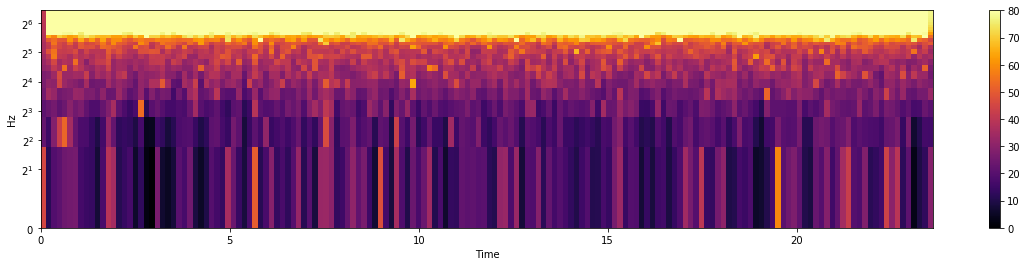

In [217]:
plt.figure(figsize=(20, 4))
f, t, Zxx = stft(filtered_signal, sf, nperseg=50)
#Zxx = 20 * np.log10(np.abs(Zxx) / np.max(Zxx))
Zxx = librosa.amplitude_to_db(np.abs(Zxx), ref=np.max)

spec = plt.pcolormesh(t, f, np.abs(Zxx), cmap='inferno')
plt.yscale('symlog', basey=2)
# plt.ylim(64, f[-1])
plt.colorbar()
plt.ylabel('Hz')
plt.xlabel('Time')

# Discrete wavelet transform
the spectrogram and welch power spectrum method, put equal weighting to t he time and frequency scales (nperseg parameter). The wavelet transform is a hierarchical grating of time and frequency information. 

It takes into account two things:
-- low frequencies tend to last for a long time.
-- higher frequencies change faster and are brief in time.
-- low frequencies do not require high temporal resoltuion

a key advantage it has over Fourier transforms is temporal resolution: it captures both frequency and location information (location in time). Fourier transforms only give good frequency resolution and not temporal resolution. This is because the nperseg limits the number of frequencies that can be sampled.

Time resolution and frqeuency resolution are  negatively correlated

Stationary signals are those where there are an integer number of cycles for all frequencies contained in the signal

DWT is good for non-stationary signals, signals whose frequency content changes over time, e.g. chirp signal
Take a forward chirp and a reverse chirp. The power spectra are the same and there would be no way to use that power spectrum to reconstruct either the forward or reverse chirp.

At what time do the frequency components occur???

Use an stft but we have equal resolution in the time and frequency domains. 
Narrow window  => good time resolution and bad frequency resolution
wide window => bad time resolution and good frquency resolution

Introduce the wavelet transform!

A wavelet is a waveform which can be stretched/compressed and moved in time.

In fourier transform, the signal can be expressed as a series of sinusoids at different frequencies. In wavelet transform, the signal is expressed as a series of wavelets of different scales and positions

# lets get wavelets using Discrete wavelet transform

In [236]:
from pywt import families

families(short=False)

['Haar',
 'Daubechies',
 'Symlets',
 'Coiflets',
 'Biorthogonal',
 'Reverse biorthogonal',
 'Discrete Meyer (FIR Approximation)',
 'Gaussian',
 'Mexican hat wavelet',
 'Morlet wavelet',
 'Complex Gaussian wavelets',
 'Shannon wavelets',
 'Frequency B-Spline wavelets',
 'Complex Morlet wavelets']

In [310]:
from pywt import Wavelet

wavelet = Wavelet('db4')
print(wavelet)

Wavelet db4
  Family name:    Daubechies
  Short name:     db
  Filters length: 8
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


In [329]:
[phi, psi, x_] = Wavelet('db4').wavefun(level=2)

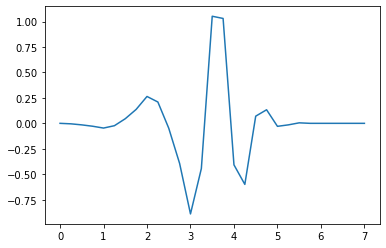

In [330]:
plt.plot(x_, psi)

at each subsequent stage the number of samples in the signal is reduced with a factor of two. At lower frequency values, you will need less samples to satisfy the Nyquist rate so there is no need to keep the higher number of samples in the signal

We start with sample rate of 173 Hz at level 1
then 88 Hz
then 44 Hz
then 22 Hz
then 10 Hz

convolving the signal with the wavelet in the time domain
is the same as multiplying the two in the frequency domain

as the scale parameter decreases, the wavelet becomes wider,  and we go to lower and lower frequencies in the power pectrum representation. We 

In [331]:
from pywt import wavedec

In [332]:
# number of levels we are interested in
level = 6

data_t = pd.DataFrame(signal).transpose()

# get the wavelet coefficients at each level in a list
coeffs_list = wavedec(data_t.values, wavelet='db4', level=level)


<class 'list'>


In [333]:
nums = list(range(1,level+1))
names=[]
for num in nums:
    names.append('D' + str(num))
names.append('A' + str(nums[-1]))

# reverse the names so it counts down
names = names[::-1] 

In [335]:
# make an empty dataframe
wavelets = pd.DataFrame()

# for each array in the list of arrays
for i, array in enumerate(coeffs_list):
    # turn into a dataframe and transpose
    level_df = pd.DataFrame(array).T
    # name the column the appropriate level name
    #print(level_df.columns[i])
    level_df.columns = [names[i]]
#     # if the wavelets df is empty...
    if wavelets.empty:
        # ... make the first level df the wavelets df
        wavelets = level_df
    # ..otherwise...
    else:
        # ... add the next levels df to another column
        wavelets = pd.concat([wavelets,level_df], axis=1)

wavelets.head()

,A6,D6,D5,D4,D3,D2,D1
0,149.861103,-1.249057,0.710087,0.309330,-8.766911,2.177197,-1.268811
1,159.818790,-0.330770,3.906305,2.936920,-27.586383,5.877633,-3.368856
2,156.324149,69.597173,38.451472,23.152126,15.058180,-4.177811,2.314636
3,143.486944,-5.522665,-52.962427,-31.019327,-3.090214,0.577935,0.505011
4,209.282563,4.834602,-12.017662,36.786787,-18.638124,1.045760,-0.489640


In [447]:
# number of coefficients in current level is half that at the preceeding level
# the number of coefficients starts off at the nyquist sampling rate, which says to capture 
# the signal sufficiently you must sample at leastd half the sampling frequency of the signal
wavelets.count()

D6      70
D5     134
D4     262
D3     518
D2    1029
D1    2052
dtype: int64

In [336]:
wavelets = wavelets.drop(['A6'], axis=1)

These are typically more associated with continuous wavelet transforms where they provide "...better time localization for short-duration, high-frequency events, and better frequency localization for low-frequency, longer-duration events [than spectrograms]"1

In [476]:
exponent_list = [2<<exponent for exponent in range(wavelets.shape[1]+1)]
wavelets_ = wavelets.copy()
for i, decom in enumerate(wavelets.sort_index(1).columns):
    # we repeat each one 2^j times because the wavelet is shifted 2^j*m times so we should repeat that coefficient 
    # 2^j where j is the level number and m is the length of the wavelet
    exponent_data = wavelets_[decom].dropna().repeat(exponent_list[i]).reset_index(drop=True) 
    if i == 0:
        plot_data = pd.DataFrame(exponent_data.abs(), 
                   columns =[decom])
    else:
        plot_data = pd.concat([plot_data, pd.DataFrame(exponent_data.abs(), columns =[decom])], axis=1)


In [477]:
plot_data.shape

(4480, 6)

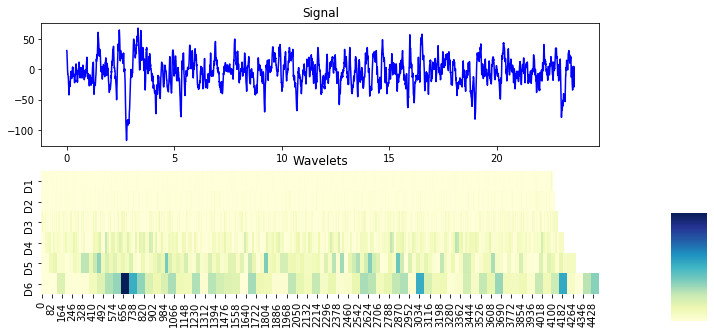

In [478]:
import seaborn as sns
fig, (sig_ax, spec_ax) = plt.subplots(2, figsize=[10, 5])
sig_ax.set_title("Signal")
sig_ax.plot(x, signal, 'b')
cbar_ax = fig.add_axes([1, 0.05, 0.05, 0.3])
spec_ax.set_title("Wavelets")
sns.heatmap(plot_data.T, ax=spec_ax, cmap="YlGnBu", cbar_ax=cbar_ax, 
              cbar_kws={"ticks":[]}
              )

# for classification, we would take different features from the wavelet transform

    Mean of the absolute values of the coefficients in each sub-band
    Average power of the wavelet coefficients in each sub-band
    Standard deviation of the coefficients in each sub-band
    Ratio of the absolute mean values of adjacent sub-bands


# log-transform

In [374]:
def log_sum(data):
    absolute_sums = data.sum()
    #print(absolute_sums)
    min_val = absolute_sums.min()
    absolute_sums_minus = absolute_sums.subtract(min_val).add(1)

    # log-transform 
    absolute_sums_log = absolute_sums_minus.apply(np.log)
    absolute_sums_log.index += '_LSWT'
    
    return absolute_sums_log

log_sum(wavelets)

D6_LSWT    5.174420
D5_LSWT    6.508800
D4_LSWT    5.624328
D3_LSWT    5.496612
D2_LSWT    4.129652
D1_LSWT    0.000000
dtype: float64

In [417]:
log_sum_ = log_sum(wavelets).to_frame().T

features = pd.concat([features, log_sum_], axis=1)

In [418]:
features

,power_delta,power_theta,power_alpha,power_beta,power_gamma,D6_LSWT,D5_LSWT,D4_LSWT,D3_LSWT,D2_LSWT,D1_LSWT,D6_LSWT,D5_LSWT,D4_LSWT,D3_LSWT,D2_LSWT,D1_LSWT
0,68.137821,27.407041,9.567442,2.527499,0.670208,5.17442,6.5088,5.624328,5.496612,4.129652,0.0,5.17442,6.5088,5.624328,5.496612,4.129652,0.0


# Average power of the wavelet coefficients in each sub-band

In [357]:
def ave(data):
    mean_data = data.mean()
    
    mean_data.index += '_mean'
    
    return mean_data

ave(wavelets)

D6_mean    1.514924
D5_mean    4.480383
D4_mean    0.787926
D3_mean    0.334392
D2_mean   -0.008254
D1_mean   -0.033942
dtype: float64

In [419]:

pd.concat([features, ave(wavelets).to_frame().T], axis=1)

,power_delta,power_theta,power_alpha,power_beta,power_gamma,D6_LSWT,D5_LSWT,D4_LSWT,D3_LSWT,D2_LSWT,...,D4_LSWT,D3_LSWT,D2_LSWT,D1_LSWT,D6_mean,D5_mean,D4_mean,D3_mean,D2_mean,D1_mean
0,68.137821,27.407041,9.567442,2.527499,0.670208,5.17442,6.5088,5.624328,5.496612,4.129652,...,5.624328,5.496612,4.129652,0.0,1.514924,4.480383,0.787926,0.334392,-0.008254,-0.033942


# Mean of the absolute values of the coefficients in each sub-band

In [358]:
def mean_abs(data):
    # get the mean of the absolute values
    mean_abs_data = data.abs().mean()
    
    mean_abs_data.index += '_mean_abs'
    
    return mean_abs_data

mean_abs(wavelets)

D6_mean_abs    69.827705
D5_mean_abs    46.364409
D4_mean_abs    27.431888
D3_mean_abs    11.297120
D2_mean_abs     3.957881
D1_mean_abs     1.570386
dtype: float64

In [420]:
pd.concat([features, mean_abs(wavelets).to_frame().T], axis=1)

,power_delta,power_theta,power_alpha,power_beta,power_gamma,D6_LSWT,D5_LSWT,D4_LSWT,D3_LSWT,D2_LSWT,...,D4_LSWT,D3_LSWT,D2_LSWT,D1_LSWT,D6_mean_abs,D5_mean_abs,D4_mean_abs,D3_mean_abs,D2_mean_abs,D1_mean_abs
0,68.137821,27.407041,9.567442,2.527499,0.670208,5.17442,6.5088,5.624328,5.496612,4.129652,...,5.624328,5.496612,4.129652,0.0,69.827705,46.364409,27.431888,11.29712,3.957881,1.570386


# Standard deviation of the coefficients in each sub-band

In [359]:
def coeff_std(data, output=False):
    # get the standard deviation of the coeficients
    std_data = data.std()
    
    std_data.index += '_std'
    
    return std_data

coeff_std(wavelets)

D6_std    94.852606
D5_std    58.684316
D4_std    34.507001
D3_std    14.209278
D2_std     4.981730
D1_std     2.107183
dtype: float64

In [421]:
pd.concat([features, coeff_std(wavelets).to_frame().T], axis=1)

,power_delta,power_theta,power_alpha,power_beta,power_gamma,D6_LSWT,D5_LSWT,D4_LSWT,D3_LSWT,D2_LSWT,...,D4_LSWT,D3_LSWT,D2_LSWT,D1_LSWT,D6_std,D5_std,D4_std,D3_std,D2_std,D1_std
0,68.137821,27.407041,9.567442,2.527499,0.670208,5.17442,6.5088,5.624328,5.496612,4.129652,...,5.624328,5.496612,4.129652,0.0,94.852606,58.684316,34.507001,14.209278,4.98173,2.107183


In [362]:
def ratio(data, output=False):
    # get the mean of the absolute values
    data = data.abs().mean()
    # get a list of the index
    decimation_levels = list(data.index)

    ratio_data=pd.Series(index=data.index)
    for level_no in range(0, len(decimation_levels)):
        # for the first decimation
        if level_no == 0:
            ratio_data.loc[decimation_levels[level_no]] = \
            data.loc[decimation_levels[level_no]]/data.loc[decimation_levels[level_no+1]]

        #for the last decimation
        elif level_no == len(decimation_levels)-1:
            ratio_data.loc[decimation_levels[level_no]] = \
            data.loc[decimation_levels[level_no]]/data.loc[decimation_levels[level_no-1]]
        else:
            before = data.loc[decimation_levels[level_no-1]]
            after = data.loc[decimation_levels[level_no+1]]
            mean_data = (before+after)/2

            ratio_data.loc[decimation_levels[level_no]] = \
            data.loc[decimation_levels[level_no]]/mean_data

    ratio_data.index += '_Ratio'
    
    if output:
        display(ratio_data)
    
    return ratio_data

In [422]:
pd.concat([features, ratio(wavelets).to_frame().T], axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


,power_delta,power_theta,power_alpha,power_beta,power_gamma,D6_LSWT,D5_LSWT,D4_LSWT,D3_LSWT,D2_LSWT,...,D4_LSWT,D3_LSWT,D2_LSWT,D1_LSWT,D6_Ratio,D5_Ratio,D4_Ratio,D3_Ratio,D2_Ratio,D1_Ratio
0,68.137821,27.407041,9.567442,2.527499,0.670208,5.17442,6.5088,5.624328,5.496612,4.129652,...,5.624328,5.496612,4.129652,0.0,1.506063,0.953416,0.95148,0.719796,0.615174,0.396775


In [424]:
features.shape

(1, 17)

# now we need to obtain these features for each observation

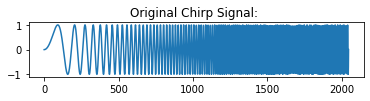

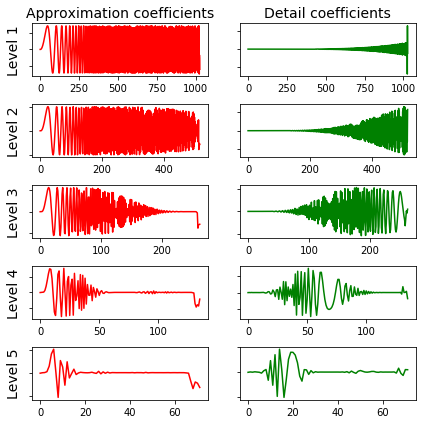

In [243]:
import pywt 
x = np.linspace(0, 1, num=2048)
chirp_signal = np.sin(250 * np.pi * x**2)
    
fig, ax = plt.subplots(figsize=(6,1))
ax.set_title("Original Chirp Signal: ")
ax.plot(chirp_signal)
plt.show()
    
data = chirp_signal
waveletname = 'sym5'
 
fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(6,6))
for ii in range(5):
    (data, coeff_d) = pywt.dwt(data, waveletname)
    axarr[ii, 0].plot(data, 'r')
    axarr[ii, 1].plot(coeff_d, 'g')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
plt.tight_layout()
plt.show()

# machine learning

We can use the Fourier Transform and wavelet transform to  transform a signal from its time-domain to its frequency domain. The peaks in the frequency spectrum indicate the most occurring frequencies in the signal. The larger and sharper a peak is, the more prevalent a frequency is in a signal. The location (frequency-value) and height (amplitude) of the peaks in the frequency spectrum then can be used as input for Classifiers like Random Forest or Gradient Boosting.

# find peaks

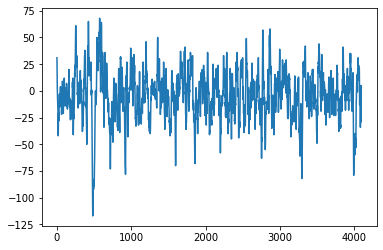

In [479]:
plt.plot(signal)

In [508]:
def findPeaks(signal, thresh):
    maxima = []
    minima = []
    for i in range(1, len(signal)-1):
        if signal[i] > thresh:
            if signal[i-1] < signal[i] >signal[i+1]:
                maxima.append(i)
        else:
            if signal[i-1] > signal[i] < signal[i+1]:
                minima.append(i)
    return minima, maxima
            
            


(500, 1000)

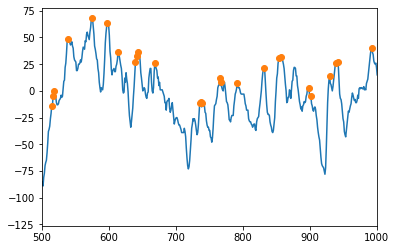

27 34


In [523]:
N = len(signal2)
sf = N / 23.6 # number of samples in 1 s
nyq_rate = sf / 2  # nyquist rate of the signal
dt = 1/sf
T = N * dt
t = np.linspace(0.0, T, N, endpoint=False)
print(dt, N, T)

0.005760312423724677 4097 23.6


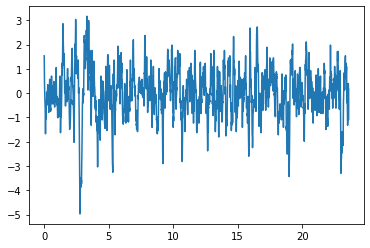

In [524]:
plt.plot(t,s)

In [525]:
# xf = fftfreq(N, dt)[:N//2]
# yf = fft(filtered_signal)
# plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
# plt.xlabel('Frequency (Hz)')
# plt.xlim([0, 40])
# plt.grid()

4097


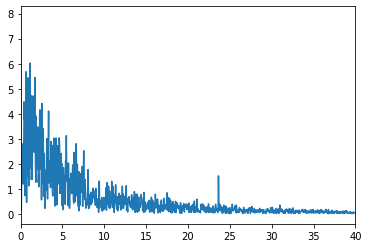

In [526]:
power = np.abs(np.fft.rfft(signal2, N))
ff = np.fft.rfftfreq(N, 1. / sf)
plt.plot(ff, 2.0/N * np.abs(power))
plt.xlim([0, 40])
print(N)

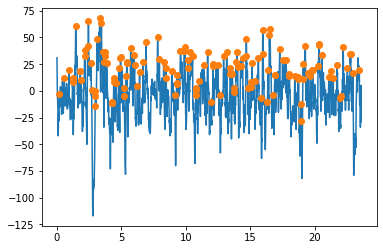

In [529]:
from scipy import signal
signal2 = df.iloc[1, :].values
b, a = signal.butter(4, 6/sf, 'high')
y = signal.filtfilt(b, a, signal2)
#plt.plot(10*y)
plt.plot(t, signal2)

minima, maxima = findPeaks(y, 15)
plt.plot(t[maxima], signal2[maxima], 'o')

In [552]:
newMaxima = [maxima[i] for i in range(1, len(maxima)) if t[maxima[i]] - t[maxima[i-1]] > 0.15]

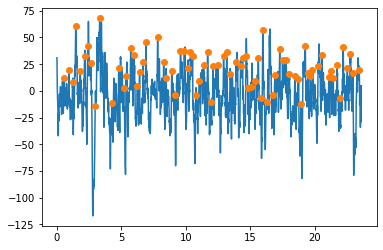

In [555]:
plt.plot(t, signal2)
plt.plot(t[newMaxima], signal2[newMaxima], 'o')


[99,
 162,
 210,
 212,
 214,
 253,
 315,
 326,
 373,
 377,
 415,
 424,
 459,
 467,
 515,
 517,
 519,
 539,
 575,
 598,
 614,
 640,
 642,
 644,
 669,
 736,
 738,
 740,
 766,
 768,
 792,
 832,
 855,
 857,
 899,
 902,
 930,
 939,
 942,
 993,
 1036,
 1045,
 1082,
 1112,
 1161,
 1200,
 1356,
 1379,
 1436,
 1466,
 1469,
 1545,
 1586,
 1610,
 1613,
 1620,
 1662,
 1715,
 1722,
 1761,
 1766,
 1797,
 1825,
 1868,
 1870,
 1872,
 1917,
 1974,
 2027,
 2072,
 2100,
 2102,
 2167,
 2190,
 2243,
 2286,
 2330,
 2332,
 2336,
 2361,
 2382,
 2384,
 2412,
 2426,
 2432,
 2471,
 2499,
 2544,
 2549,
 2578,
 2606,
 2609,
 2624,
 2660,
 2711,
 2743,
 2770,
 2775,
 2821,
 2839,
 2859,
 2868,
 2903,
 2934,
 2937,
 2998,
 3036,
 3085,
 3125,
 3128,
 3201,
 3242,
 3251,
 3283,
 3289,
 3310,
 3313,
 3343,
 3379,
 3410,
 3439,
 3442,
 3514,
 3525,
 3527,
 3565,
 3660,
 3689,
 3719,
 3769,
 3805,
 3821,
 3852,
 3909,
 3947,
 3953,
 3984,
 4070]

In [534]:
t

array([0.00000000e+00, 5.76031242e-03, 1.15206248e-02, ...,
       2.35827191e+01, 2.35884794e+01, 2.35942397e+01])

# Verily interview 1 with Carson: coding problem on computing Z-score of a really big matrix

In [556]:
def zscore(matrix):
    m = matrix.shape[0]
    sums = []
    sq_sums = []

    chunk = m // 10
    for i in range(0, m, chunk):
        sums.append(np.sum(matrix[i:i+chunk], axis=0))  #  matrix[i:i+chunk] <--- (chunk, features)
        sq_sums.append(np.sum(matrix[i:i+chunk]**2, axis=0))

    sums = np.array(sums)

    sq_sums=np.array(sq_sums).sum(axis=0)
    
    mean_ = np.sum(sums, axis=0)/m

    var = sq_sums/m - mean_**2
   
    std_ = np.sqrt(var)

    return (matrix - mean_)/std_

In [561]:
matrix = np.random.random((200000,50))

print(np.mean(zscore(matrix), axis=0)) # zero mean
print(np.var(zscore(matrix), axis=0)) # unit variance

[-5.14418397e-15 -1.72226622e-15  3.68095221e-15 -5.33097330e-15
  7.32910399e-16 -7.73590858e-15  2.37973363e-15  1.08857076e-15
 -4.16554971e-15  1.21889832e-15 -5.17798027e-16  1.78616309e-15
 -4.86334861e-15  8.83459972e-16  4.13235168e-15  2.32528552e-15
  1.91971661e-15 -2.97732838e-15 -1.09673381e-15  3.25937555e-15
  7.14986959e-16  6.49477139e-16 -3.13355675e-15 -2.55918620e-16
 -2.43332798e-15 -2.55843081e-15  9.85115045e-16 -1.25112143e-16
  3.08661263e-15 -1.94298355e-15  1.95982452e-15  6.27775887e-16
 -2.58430777e-15  3.33240879e-15 -2.99076319e-16 -1.70134462e-15
 -1.54832924e-15  5.32892619e-16 -5.40005818e-16 -3.58075208e-15
 -2.12616147e-15  1.22402533e-15  8.54465387e-16  2.94377966e-15
 -4.50985915e-16  5.51485524e-16 -7.65054686e-16  9.14579523e-17
 -2.75189982e-15  1.87932447e-15]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


# design a 1D median filter

In [569]:
# Please implement an 1-D median filter given an 1-D array x and a kernel size k. You should check if the kernel size is odd – if not, please raise an exception.

# x = [5, 8, 9, 5, 1, 2, 1], k = 3
# output = [5, 8, 8, 5, 0, 0, 0]

# 0 5 8
# 5 8 9
# 8 9 5
# 9 5 0

# k = 5
# 0 5 8 9 5 -> 0 0 5 8 9
# 1, 2, 1, 0, 0

def medFilt(x, k):
    if k % 2 == 0:
        raise Exception("you  must provide odd k") 

    zeros = [0] * (k//2)

    x = zeros + x

    output = []
    for i in range(0, len(x)-k + 1):
        window = x[i:i+k]
        print(window)
        sortedWin = sorted(window)
        
        output.append(sortedWin[k//2])


    return output + zeros


x = [5, 8, 9, 5, 0, 0, 1]
k = 5
print(medFilt(x, k))
   



[0, 0, 5, 8, 9]
[0, 5, 8, 9, 5]
[5, 8, 9, 5, 0]
[8, 9, 5, 0, 0]
[9, 5, 0, 0, 1]
[5, 5, 5, 5, 1, 0, 0]
